<div class="alert alert-block alert-danger">
    <b> Unraveling the cytoskeletal architecture of cancer cells: a novel computational approach to predict cell fate - CODE</b> 
    
 **7 - RESULTS ANALYSIS**
    
**Author**: Diogo Fróis Vieira
</div>

<div class="alert alert-block alert-info">
    
 **IMPORTS**
    
</div>

In [5]:
# IMPORTS
# Math, image processing and other useful libraries
from __future__ import print_function, unicode_literals, absolute_import, division
import os

import pandas as pd
import numpy as np
import cv2
from collections import OrderedDict
import copy
import math
import pickle
from matplotlib.ticker import MaxNLocator
from itertools import combinations

# Image processing
from skimage.measure import regionprops
from skimage.filters import meijering, sato, frangi, hessian, threshold_otsu
from skimage.morphology import extrema, skeletonize
from skimage.transform import probabilistic_hough_line
from skimage.draw import disk, circle_perimeter
from scipy.ndimage import gaussian_filter, grey_closing
from scipy.spatial import distance_matrix
from skimage import data, restoration, util
from roipoly import RoiPoly
from matplotlib_scalebar.scalebar import ScaleBar
from biosppy.signals import tools
from biosppy.stats import pearson_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as pltc
import matplotlib.colors as colors
import seaborn as sns

# Widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

# Feature Extraction (.py files by Teresa Parreira)
# from CytoSkeletonPropsMorph import CytoSkeletonPropsMorph
# from CytoSkeletonRegionPropsInt import RegionPropsInt
# from FreqAnalysis import FreqAnalysis
# from GLCM import GLCM

# Graph
import sknw
import networkx as nx
from scipy.signal import argrelextrema

# 
from skan import Skeleton, summarize,draw
from skan.csr import skeleton_to_csgraph, sholl_analysis,make_degree_image
import scipy as sp
import scipy.sparse
from matplotlib.patches import Circle

from framework.Functions import cv2toski,pylsdtoski,polar_to_cartesian, remove_not1D, quantitative_analysis,hist_bin,hist_lim,branch,graphAnalysis
from framework.importing import *
from framework.preprocessingCYTO import *
#from framework.PreProcessingNUCL import excludeborder, nuclei_preprocessing, df_nuclei_preprocessing, nuclei_segmentation
from framework.processing import *
from framework.visualization import *
from framework.analysis import plot_barplot
from framework.processing_LSF import *
from framework.processing_DCF import *
from framework.processing_CNF import *
#from fractal_dimension import fractal_dimension
#from fractal_analysis_fxns import boxcount,boxcount_grayscale,fractal_dimension,fractal_dimension_grayscale,fractal_dimension_grayscale_DBC

print('📚 All libraries successfully imported 📚')

📚 All libraries successfully imported 📚


<div class="alert alert-block alert-info">
    
 **DIRECTORIES**
    
</div>

In [10]:
# Define dataset folder.
folder      = os.path.dirname(os.getcwd()) + "\\Datasets\\Set 1-a-tubulin_Sofia"

# Import images from CYTO, NUCL and RGB folders.
options     = ["CYTO","NUCL","RGB"]

# Function to automatically retrieve image labels and indexes.
denominator = label_tubulin

# Dictionary with keys "CYTO", "NUCL", "RGB".
data = init_import(folder,options,denominator)

# Import ROIs
ROIs = pickle.load(open(folder + '//ROIs//ROIs_TEST.pkl', 'rb'))

# Import processed results
ResultsDF = pd.read_pickle(folder + "\\ResultsDF_TEST_DONE.pkl")

TiffPage 0: IndexError: tuple index out of range


>>> [RGB] added.
>>> [CYTO] added.
>>> [NUCL] added.


In [11]:
ResultsDF

,Path,Name,Img Index,Label,Image Size,Resolution,Mask,Skeleton,Patch:Deconvoluted Cyto,Patch:Deconvoluted Nucl,...,LSF1D:Number of Lines,LSF1D:OOP,CNF1D:Number of Branches,CNF2D:Branch Lengths,CNF2D:Branch Orientations,CNF2D:Branch Orientations PCA,CNF2D:Local Average Branch Distances,CNF2D:Local Average Bundling Score,CNF2D:Local Average Branch Orientation,CNF2D:Distances to Centroid
0,C:\Users\diogo\OneDrive - Universidade de Lisb...,MAX_9_6IF_CHO_L_w3z_decon_ch02_PS.tif,9,WT,"(1040, 1388)","(1, 1.6e-05, 1.6e-05)","([676, 676, 676, 676, 677, 677, 677, 677, 677,...","([688, 688, 688, 688, 689, 689, 690, 690, 690,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,142,0.014352,137,"[0.7785838738653232, 0.7117919369326616, 2.780...","[67.5, 78.75, 154.6875, 6.923076923076923, 118...","[67.5, 72.85656151139553, 171.99931576466966, ...","[10.054, 8.234, 10.293, 7.551, 7.107, 10.506, ...","[766.949, 811.736, 468.526, 65.312, 672.193, 1...","[54.643, 78.75, 32.236, 6.923, 73.125, 9.643, ...","[7.084, 2.72, 5.771, 3.821, 5.981, 8.258, 8.52..."


In [43]:
def getskelfrom(ResultsRow):
    idx = ResultsRow['Img Index']
    image = data['CYTO_PRE'].loc[idx]['Skeleton'] * retrieve_mask(ResultsRow['Mask'],ResultsRow['Image Size'])
    
    non_zero_indices = np.where((image*1)!=0)
    
    return non_zero_indices



ResultsDF = pd.read_pickle(folder + "\\ResultsDF_9_jan_24.pkl")
ResultsDF['Mask'] = [np.where((mask*1)!=0) for mask in ResultsDF['Mask']]
ResultsDF['Image Size'] = [(1040, 1388) for i in range(len(ResultsDF))]
ResultsDF['Skeleton'] = [getskelfrom(row) for index,row in ResultsDF.iterrows()]

In [44]:
data['NUCL_PRE'] = pd.read_pickle(folder + "\\NUCL_PRE\\NUCL_PRE.pkl") # pd.read_pickle(os.getcwd() + "\\NUCL_PRE_2D_StarDist.pkl") #
data['CYTO_PRE'] = pd.read_pickle(folder + "\\CYTO_PRE\\CYTO_PRE.pkl") 

In [19]:
ResultsDF

,Name,Img Index,Label,Mask,Patches,Lines,Graph,LSF2D:Angles,LSF2D:Distances to Centroid,LSF2D:Triangle Areas,...,LSF:Radial Pos 2,LSF:Radial Score 2,LSF1D:RS NucCent Distance (LinReg) (scaled),LSF2D:Distances to Centroid (LinReg) (scaled),LSF2D:Alphas (LinReg),LSF1D:Circular Variance (LinReg),DCF:AreaRatio 6,LSF1D:Radial Score 2,LSF2D:Radial Pos 2,Image Size
0,MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif,38,No transfection,"([2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6,...","[[[False, False, False, False, False, False, F...","[((846.96, 125.385), (843.154, 135.458)), ((90...","[ (1, 2)\t1.0\n (2, 1)\t1.0\n (2, 4)\t1.0\n...","[24.256, 56.447, 77.093, 39.697, 65.666, 64.38...","[61.939, 143.836, 28.124, 126.194, 41.283, 66....","[137.0, 408.228, 53.471, 183.353, 64.306, 232....",...,"[300, 890]",0.526,18.614870,"[29.481, 29.431, 29.09, 28.858, 28.468, 28.362...","[40.022, 14.647, 86.865, 3.481, 41.068, 41.948...",0.802674,0.404844,0.372,"[203, 825]","(1040, 1388)"
1,MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif,38,No transfection,"([565, 565, 565, 565, 565, 566, 566, 566, 566,...","[[[False, False, False, False, False, False, F...","[((1226.05, 591.863), (1229.906, 588.782)), ((...","[ (1, 2)\t1.0\n (2, 1)\t1.0\n (2, 4)\t1.414...","[11.074, 26.265, 40.852, 6.218, 77.168, 26.269...","[95.139, 23.384, 90.483, 73.611, 26.804, 96.53...","[45.096, 18.922, 177.546, 15.493, 70.073, 129....",...,"[625, 1075]",0.528,11.126836,"[11.72, 11.946, 11.728, 10.398, 10.635, 11.596...","[82.106, 20.13, 35.896, 25.086, 9.016, 72.525,...",0.825206,0.769107,0.362,"[669, 1039]","(1040, 1388)"
2,MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif,38,No transfection,"([12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, ...","[[[False, False, False, False, False, False, F...","[((826.21, 118.655), (825.066, 124.886)), ((82...","[ (1, 2)\t1.0\n (2, 1)\t1.0\n (2, 3)\t1.414...","[28.672, 55.951, 31.395, 27.53, 25.057, 22.241...","[74.211, 25.097, 67.937, 28.992, 35.359, 27.39...","[112.783, 64.456, 149.307, 34.752, 69.741, 65....",...,"[300, 890]",0.523,18.614870,"[28.417, 28.12, 27.203, 28.024, 24.15, 22.804,...","[21.128, 61.22, 36.62, 42.571, 12.068, 5.511, ...",0.788797,0.408720,0.368,"[150, 815]","(1040, 1388)"
3,MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif,38,No transfection,"([27, 28, 28, 29, 29, 29, 30, 30, 30, 30, 31, ...","[[[False, True, False, False, False, False, Fa...","[((881.97, 87.737), (872.975, 72.653)), ((879....","[ (1, 2)\t1.0\n (2, 1)\t1.0\n (2, 3)\t1.414...","[20.094, 57.405, 61.997, 11.955, 15.799, 30.33...","[83.948, 26.429, 102.525, 141.98, 98.202, 133....","[253.26, 118.564, 241.509, 224.165, 172.172, 6...",...,"[305, 925]",0.397,23.393638,"[21.029, 19.481, 19.62, 19.194, 18.717, 18.365...","[25.824, 3.513, 50.399, 17.071, 49.743, 26.505...",0.751187,0.412491,0.404,"[32, 855]","(1040, 1388)"
4,MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif,38,No transfection,"([71, 72, 72, 73, 73, 73, 74, 74, 74, 74, 75, ...","[[[False, True, True, False, False, False, Fal...","[((919.221, 167.758), (920.078, 160.075)), ((9...","[ (1, 2)\t1.0\n (1, 3)\t1.4142135623730951\n...","[48.07, 4.47, 65.924, 53.998, 33.861, 23.61, 5...","[32.138, 49.333, 81.292, 30.35, 80.794, 123.43...","[92.418, 7.798, 208.683, 138.812, 203.711, 222...",...,"[315, 985]",0.386,21.406471,"[16.208, 15.69, 13.847, 14.112, 13.882, 12.406...","[13.789, 81.911, 11.709, 78.614, 12.811, 48.03...",0.826396,0.549199,0.386,"[318, 983]","(1040, 1388)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,MAX_40_IF6_CHO_L-W6_Z_decon_ch02_PS.tif,40,Del38_46,"([539, 540, 540, 540, 540, 541, 541, 541, 541,...","[[[True, False, False, False, False, False, Fa...","[((1302.876, 636.71), (1315.898, 650.104)), ((...","[ (1, 2)\t1.0\n (2, 1)\t1.0\n (2, 3)\t1.414...","[6.437, 51.558, 70.196, 2.449, 35.981, 45.614,...","[24.55, 54.236, 11.064, 16.849, 37.888, 7.025,...","[25.706, 253.343, 45.029, 1.354, 60.215, 14.18...",...,"[570, 1250]",0.385,12.212995,"[14.554, 9.818, 9.586, 6.89, 7.84, 9.681,

In [ ]:
def centroid_find(ResultsRow,CentroidsDF):
    x_,y_   = ResultsRow['Mask']
    imgIndex = ResultsRow['Img Index']
    df = CentroidsDF[imgIndex]
    # Find centroid
    for index,row in df.iterrows():
        if (round(row['Centroid'][0]),round(row['Centroid'][1])) in list(zip(x_,y_)):
            centroid = (row['Centroid'][0],row['Centroid'][1])
            contour  = row['Contour'][0][:,0]
            
            break
    try:
        centroid
    except:
        centroid = (0,0)
        contour = (0,0)
        print(index,'centroid not found. set to (0,0)')
        
    return centroid,contour

ResultsDF['Nucleus Centroid'] = [centroid_find(row,CentroidsDF)[0] for index,row in ResultsDF.iterrows()]
ResultsDF['Nucleus Contour'] = [centroid_find(row,CentroidsDF)[1] for index,row in ResultsDF.iterrows()]

In [32]:
CentroidsDF = pickle.load(open(folder + '//Centroids.p', 'rb'))

In [3]:
sep = create_separate_DFs(ResultsDF,options=["FULL"])
FULL = sep["FULL"]

<div class="alert alert-block alert-info">
    
 **SELECT CELL**
    
</div>

In [26]:
def dropdown_cell_eventhandler(change):
    global cell
    cell = dropdown_image.value
    lab = ResultsDF.loc[cell]['Label']
    print('Cell ' + str(cell) + ' (' + str(lab) +') selected.')

dropdown_image = widgets.Dropdown(description =  'Select Cell:' , options = ['...'] + list(ResultsDF.index))
dropdown_image.observe(dropdown_cell_eventhandler, names='value')
display(dropdown_image)

Dropdown(description='Select Cell:', options=('...', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

Cell 5 (No transfection) selected.
Cell 11 (No transfection) selected.


<div class="alert alert-block alert-info">
    
 **PLOT INTENSITY**
    
</div>

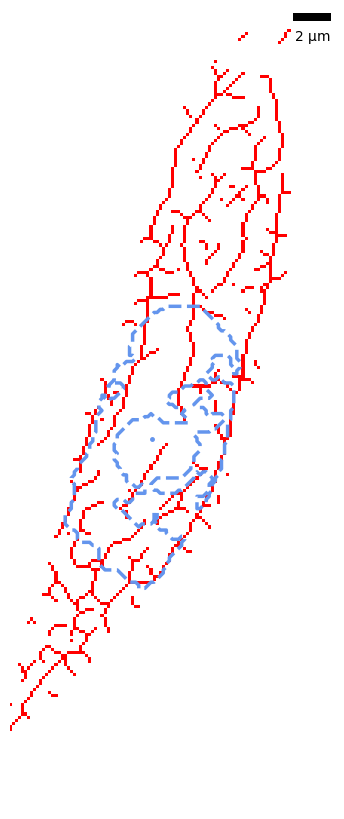

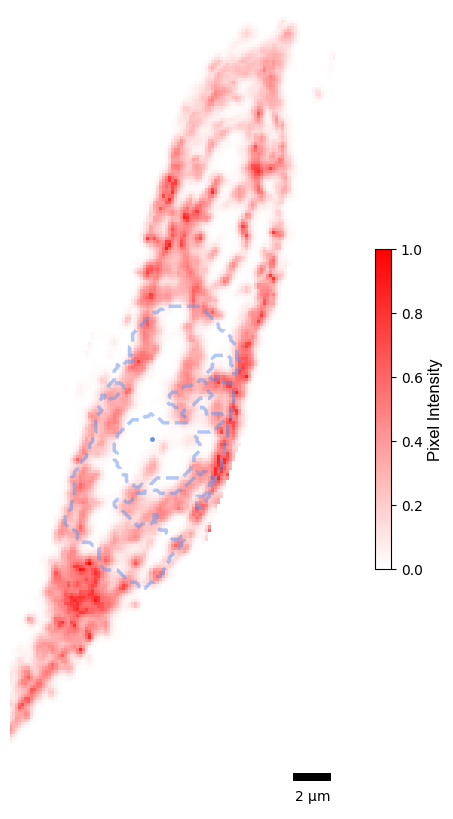

In [72]:
fig_sk,fig_int = intensity_plotter(ResultsRow = ResultsDF.loc[cell],
                                  data       = data,
                                  save       = False)    #'complexity_skel2'

<div class="alert alert-block alert-info">
    
 **PLOT LINES**
    
</div>

[261.0, 261.0]


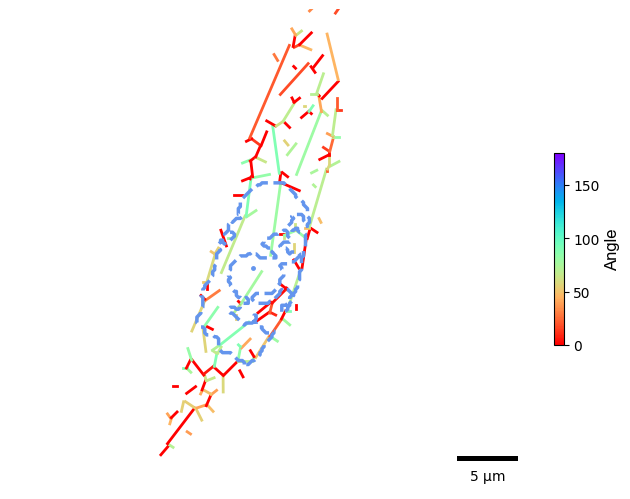

In [74]:
# PLOT LINES
%matplotlib inline

cmap     = pltc.rainbow_r
cm       = truncate_colormap(cmap, 0, 1, 300)

# ORIENTATION
fig_lines = line_plotter(ResultsRow = ResultsDF.loc[cell],
             data=data,
             feat='LSF2D:Theta',
             cmap=cm,
             normalize_bounds=[0, 180],
             colorbar_label='Angle',
             line_data_origin = 'Lines LinReg',
             overlay=False,
             save='orientation_lines_exp')

# BUNDLING
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Local Line Distance (LinReg)",
#              cmap=cm,
#              normalize_bounds=[0,4],
#              colorbar_label='Local Line Distance (µ)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='bundling_lines0')

# PARALLELISM
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Angle Difference (LinReg)",
#              cmap=cm,
#              normalize_bounds=[0,90],
#              colorbar_label='Mean Angle Difference (º)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='parallelism_lines2')

# COMPACTNESS & QUANTITY
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat=None,
#              cmap=cm,
#              normalize_bounds=None,
#              colorbar_label=None,
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='compactness_lines1')

# RADIALITY
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Alphas (LinReg)",
#              cmap=cm,
#              normalize_bounds=[0,90],
#              colorbar_label='Angle (º)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save=False)

# CYTO-NUC INTERACTION
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Distances to Centroid (LinReg) (scaled)",
#              cmap=cm,
#              normalize_bounds=[0,30],
#              colorbar_label='Distance (μm)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='cytonuc_lines0')

In [71]:
def plot_radial(ResultsRow,overlay,normalize_bounds,colorbar_label,save):
    from skimage.morphology import square,dilation
    from skimage.filters import apply_hysteresis_threshold
    
    fig,ax=plt.subplots(figsize=(15,15))
    t = dilation(ResultsRow['LSF3D:Mat Scores'], square(1))
    
    # Plot background
    if overlay == None:
        ax.imshow(np.zeros((1040, 1388)),cmap='gray',alpha=0)
    if overlay == 'sk':
        ax.imshow(1-ResultsRow['Mask']*TextureDF['Skeleton'][ResultsRow['Img Index']],cmap='gray',alpha=0.5)
        #ax.imshow(np.max(ResultsRow['Patches'][1]) - ResultsRow['Patches'][1],cmap='gray',zorder=2)
    
    # Get contour mask
    img = data['CYTO']['Image'][ResultsRow['Img Index']] * ResultsRow['Mask']
    res = apply_hysteresis_threshold(img,threshold_otsu(img)*0.3,threshold_otsu(img))
    
    
    # Plot RS
    mycmap = pltc.get_cmap('Reds')
    mycmap.set_under('w')
    ax.imshow(t*res,cmap=mycmap,vmin=.001,vmax=0.5)
    ax.axis('off')
    
    # Plot points
    x_,y_   = np.where((ResultsRow['Mask']*1) != 0)
    plot_nuclei_contours(CentroidsDF,ResultsRow['Img Index'],[x_,y_],ax)
    
    #ax.plot(ResultsRow['Nucleus Centroid'][1],ResultsRow['Nucleus Centroid'][0],'o',color='#6495ED',markersize=12,zorder=8)
    #ax.plot(ResultsRow['Nucleus Contour'][:,0],ResultsRow['Nucleus Contour'][:,1],'--',color='#6495ED',zorder=11,linewidth=2.5)
    ax.plot(ResultsRow['LSF2D:Radial Pos 2'][1],ResultsRow['LSF2D:Radial Pos 2'][0],'o',color='#EDE7B1',zorder=12,markersize=14)
    
    # Get bounds for color map (either 'default' or [0,90], etc)
    if normalize_bounds == 'default':
        #normalize_bounds = [0,ResultsRow['LSF1D:Radial Score 2']]
        normalize_bounds = [0,0.5]

        
    # Colorbar
    if colorbar_label != None:
        cbar = fig.colorbar(pltc.ScalarMappable(norm=plt.Normalize(normalize_bounds[0], normalize_bounds[1]), cmap=mycmap), ax=ax, shrink = 0.4)
        cbar.set_label(colorbar_label,fontfamily='arial',fontsize=12)
        #cbar.set_ticks(np.linspace(0,1,5,endpoint=True))

    # Scale Bar
    scalebar = ScaleBar(0.16125,"um",color='k',box_alpha=0,dimension='si-length',location='lower right') 
    ax.add_artist(scalebar)
    
    # Lims
#     ax.set_ylim([min(ResultsRow['Patches'][4]),max(ResultsRow['Patches'][4])])
#     ax.set_xlim([min(ResultsRow['Patches'][5]),max(ResultsRow['Patches'][5])])
    ax.set_ylim([min(x_),max(x_)])
    ax.set_xlim([min(y_),max(y_)])
    
    # Adjust and Show
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save != False:
        plt.savefig(folder + str("\\") + str(save) + ".pdf",format='pdf',transparent=True,bbox_inches='tight')
    fig.show()
    
    return print('Done.')

C:\Users\diogo\AppData\Local\Temp\ipykernel_20148\2753092477.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Done.


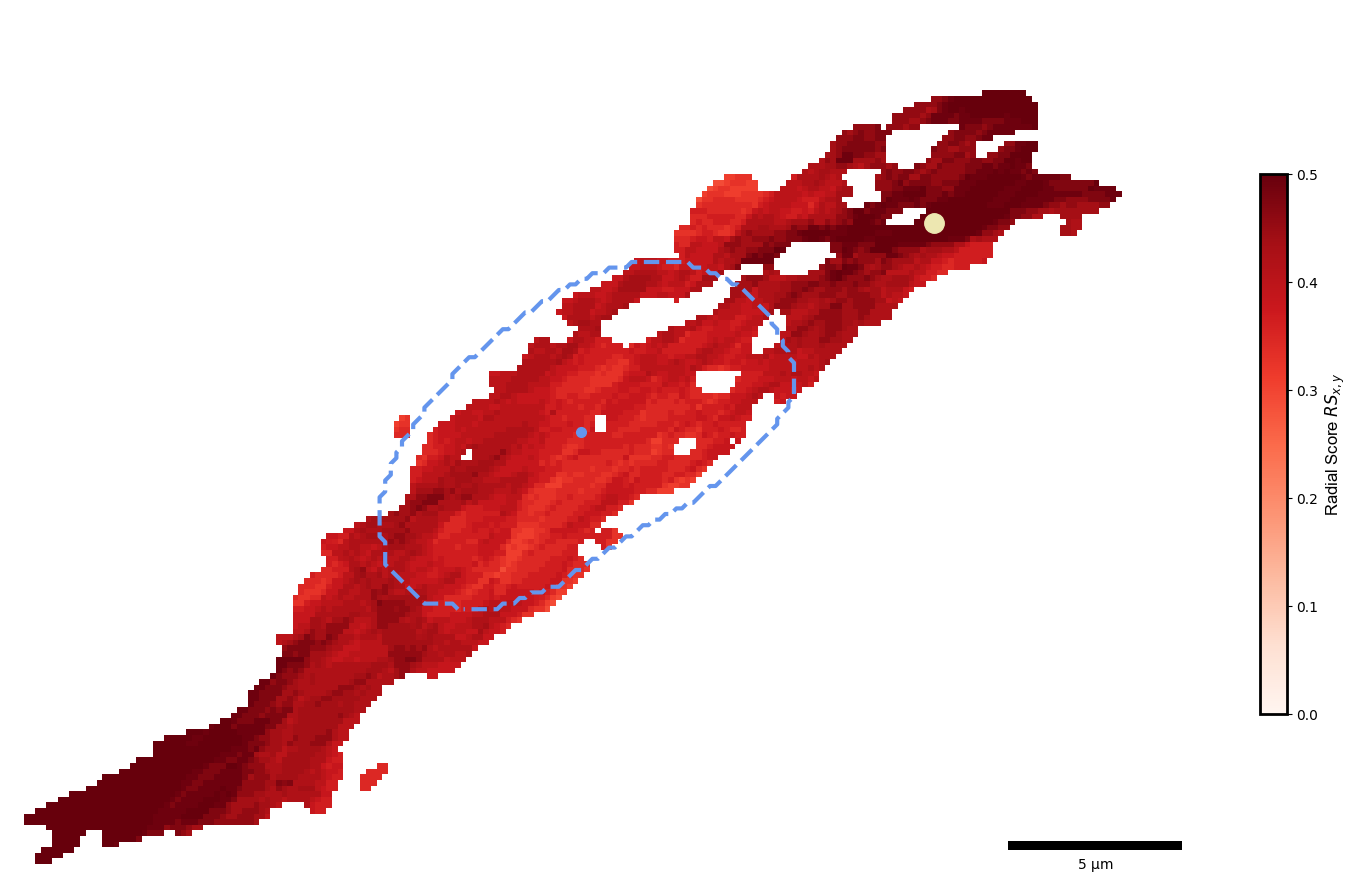

In [80]:
plot_radial(ResultsRow       = ResultsDF.loc[488], 
            overlay          = None, 
            normalize_bounds = 'default',
            colorbar_label   = 'Radial Score $RS_{x,y}$',
            save             = "RS2_map") 

<div class="alert alert-block alert-info">
    
 **PLOT GRAPH**
    
</div>

In [17]:
cmap     = pltc.rainbow
cm       = truncate_colormap(cmap, 0, 1, 300)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'branch-distance',
#               cmap             = cm,
#               normalize_bounds = [0,6],
#               colorbar_label   = 'Length (μm)',
#               nodes            = True,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = 'morphology_graph0')

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Branch Orientation',
#               cmap             = cm,
#               normalize_bounds = [0,180],
#               colorbar_label   = 'Angle (º)',
#               nodes            = True,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Local Average Branch Distance',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = 'Distance (μm)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Mean Filament Thickness',
#               cmap             = cm,
#               normalize_bounds = [1,2],
#               colorbar_label   = 'Thickness (μm)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Local Average Branch Orientation',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = 'Angle (º)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Local Average Bundling Score',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = 'Distance * Angle (umº)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

fig_graph = graph_plotter(ResultsRow       = ResultsDF.loc[cell],
                          data             = data,
                          feat             = 'CNF2D:Distances to Centroid',
                          cmap             = cm,
                          normalize_bounds = 'default',
                          colorbar_label   = 'Distance (μm)',
                          nodes            = False,
                          main_branch      = False,
                          overlay          = None,
                          scalebar         = True,
                          save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               cmap             = cm,
#               feat             = None,
#               normalize_bounds = 'default',
#               colorbar_label   = None,
#               nodes            = True,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = 'figure4_graph')

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'branch-type',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = None,
#               nodes            = True,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = 'connectivity2')

#graph_plotter(ResultsRow=ResultsDF.loc[cell],data=data,feat=None,cmap=cm,normalize_bounds='default',colorbar_label=None,nodes=True,main_branch=False, overlay = None,scalebar=False, save='preprocessing_cellX_paper_graph')

KeyError: 'Skeleton'

<div class="alert alert-block alert-info">
    
 **GLOBAL ANALYSIS**
    
</div>

# PIE CHARTS

# BARPLOTS

In [ ]:
fig_bar = plot_barplot_paper(FULL,
                   feature = [
                              'LSF1D:Number of Lines',
                              ])